## The Warren Buffet Comparator function

Annual_return: The average yearly return of the strategy, annualized from the test period.

Sharpe: The risk-adjusted return, measuring excess return per unit of volatility.

Max_drawdown: The largest observed loss from a peak to a trough in the strategy's equity curve.

Volatility: The annualized standard deviation of daily returns, representing risk.

Final_balance: The ending portfolio value after applying the strategy over the test period.

In [ ]:
def compare_with_buffett(strategy_returns, strategy_name="Our Strategy", initial_capital=100000, 
                         start_date=None, end_date=None, trading_dates=None, position_series=None):
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import yfinance as yf
    from IPython.display import display, HTML
    
    # Determine trading dates
    if trading_dates is None:
        if isinstance(strategy_returns, pd.Series) or isinstance(strategy_returns, pd.DataFrame):
            trading_dates = strategy_returns.index
        else:
            if start_date is None or end_date is None:
                raise ValueError("Must provide either trading_dates or start_date and end_date")
            # Create trading dates from start and end dates
            trading_dates = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # Download asset and Buffett data
    brk_b = yf.download('BRK-B', start=trading_dates[0], end=trading_dates[-1] + pd.DateOffset(days=1))
    brk_b = brk_b.reindex(trading_dates)
    brk_b['log_return'] = np.log(brk_b['Close']).diff().fillna(0)
    
    # Initialize results DataFrame
    results = pd.DataFrame(index=trading_dates)
    
    # Process strategy returns or position signals
    if position_series is not None:
        # We have position signals, so need asset price data
        asset_ticker = position_series.name if hasattr(position_series, 'name') else 'TSLA'
        asset_data = yf.download(asset_ticker, start=trading_dates[0], end=trading_dates[-1] + pd.DateOffset(days=1))
        asset_data = asset_data.reindex(trading_dates)
        asset_data['log_return'] = np.log(asset_data['Close']).diff().fillna(0)
        
        # Calculate strategy returns from positions
        results['position'] = position_series
        results['asset_return'] = asset_data['log_return']
        results['strategy_return'] = results['position'].shift(1) * results['asset_return']
        results['strategy_return'].iloc[0] = 0  # No return on first day
    else:
        # We already have strategy returns
        results['strategy_return'] = strategy_returns
    
    # Calculate cumulative returns and account balances
    results['strategy_cum_return'] = (1 + results['strategy_return']).cumprod() - 1
    results['strategy_balance'] = initial_capital * (1 + results['strategy_cum_return'])
    
    # Calculate Buffett's returns
    results['buffett_return'] = brk_b['log_return']
    results['buffett_cum_return'] = (1 + results['buffett_return']).cumprod() - 1
    results['buffett_balance'] = initial_capital * (1 + results['buffett_cum_return'])
    
    # Calculate buy & hold returns for the asset (if we have asset data)
    if 'asset_return' in results.columns:
        results['asset_cum_return'] = (1 + results['asset_return']).cumprod() - 1
        results['asset_balance'] = initial_capital * (1 + results['asset_cum_return'])
    
    # Calculate performance metrics
    days = len(results)
    annualization_factor = 252 / days
    
    # Function to calculate maximum drawdown
    def calculate_max_drawdown(returns):
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.cummax()
        drawdown = (cumulative / running_max) - 1
        return drawdown.min()
    
    # Strategy metrics
    strategy_annual_return = (1 + results['strategy_cum_return'].iloc[-1]) ** annualization_factor - 1
    strategy_sharpe = results['strategy_return'].mean() / results['strategy_return'].std() * np.sqrt(252)
    strategy_max_dd = calculate_max_drawdown(results['strategy_return'])
    strategy_volatility = results['strategy_return'].std() * np.sqrt(252)
    
    # Buffett metrics
    buffett_annual_return = (1 + results['buffett_cum_return'].iloc[-1]) ** annualization_factor - 1
    buffett_sharpe = results['buffett_return'].mean() / results['buffett_return'].std() * np.sqrt(252)
    buffett_max_dd = calculate_max_drawdown(results['buffett_return'])
    buffett_volatility = results['buffett_return'].std() * np.sqrt(252)
    
    # Asset metrics (if available)
    if 'asset_return' in results.columns:
        asset_name = asset_ticker if 'asset_ticker' in locals() else 'Asset'
        asset_annual_return = (1 + results['asset_cum_return'].iloc[-1]) ** annualization_factor - 1
        asset_sharpe = results['asset_return'].mean() / results['asset_return'].std() * np.sqrt(252)
        asset_max_dd = calculate_max_drawdown(results['asset_return'])
        asset_volatility = results['asset_return'].std() * np.sqrt(252)
    
    # Create performance summary table
    metrics = ['Total Return', 'Annual Return', 'Sharpe Ratio', 'Maximum Drawdown', 
               'Annual Volatility', 'Final Balance', 'Win Rate']
    
    summary_data = {
        'Metric': metrics,
        f'{strategy_name}': [
            f"{results['strategy_cum_return'].iloc[-1]:.2%}", 
            f"{strategy_annual_return:.2%}", 
            f"{strategy_sharpe:.2f}", 
            f"{strategy_max_dd:.2%}", 
            f"{strategy_volatility:.2%}",
            f"${results['strategy_balance'].iloc[-1]:,.2f}",
            f"{(results['strategy_return'] > 0).mean():.2%}"
        ],
        'Warren Buffett (BRK-B)': [
            f"{results['buffett_cum_return'].iloc[-1]:.2%}", 
            f"{buffett_annual_return:.2%}", 
            f"{buffett_sharpe:.2f}", 
            f"{buffett_max_dd:.2%}", 
            f"{buffett_volatility:.2%}",
            f"${results['buffett_balance'].iloc[-1]:,.2f}",
            f"{(results['buffett_return'] > 0).mean():.2%}"
        ]
    }
    
    if 'asset_return' in results.columns:
        summary_data[f'{asset_name} Buy & Hold'] = [
            f"{results['asset_cum_return'].iloc[-1]:.2%}", 
            f"{asset_annual_return:.2%}", 
            f"{asset_sharpe:.2f}", 
            f"{asset_max_dd:.2%}", 
            f"{asset_volatility:.2%}",
            f"${results['asset_balance'].iloc[-1]:,.2f}",
            f"{(results['asset_return'] > 0).mean():.2%}"
        ]
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print and display performance summary
    print(f"\n===== {strategy_name} vs. Warren Buffett Performance Summary =====")
    display(HTML(summary_df.to_html(index=False, classes='table table-striped table-hover')))
    
    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['strategy_cum_return'] * 100, label=f'{strategy_name}', linewidth=2)
    plt.plot(results.index, results['buffett_cum_return'] * 100, label='Warren Buffett (BRK-B)', linewidth=2)
    if 'asset_return' in results.columns:
        plt.plot(results.index, results['asset_cum_return'] * 100, label=f'{asset_name} Buy & Hold', linewidth=2)
    plt.title('Cumulative Return Comparison (%)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Return results for further analysis if needed
    output = {
        'results': results,
        'summary': summary_df,
        'metrics': {
            'strategy': {
                'annual_return': strategy_annual_return,
                'sharpe': strategy_sharpe,
                'max_drawdown': strategy_max_dd,
                'volatility': strategy_volatility,
                'final_balance': results['strategy_balance'].iloc[-1]
            },
            'buffett': {
                'annual_return': buffett_annual_return,
                'sharpe': buffett_sharpe,
                'max_drawdown': buffett_max_dd,
                'volatility': buffett_volatility,
                'final_balance': results['buffett_balance'].iloc[-1]
            }
        }
    }
    
    if 'asset_return' in results.columns:
        output['metrics']['asset'] = {
            'annual_return': asset_annual_return,
            'sharpe': asset_sharpe,
            'max_drawdown': asset_max_dd,
            'volatility': asset_volatility,
            'final_balance': results['asset_balance'].iloc[-1]
        }
    
    return output

## Dealing with data leakage 

In [2]:
import ta
def remove_data_leakage(df, model_type='pca', verbose=True):
    """
    Transform features to prevent data leakage while preserving predictive power
    
    Parameters:
    -----------
    df : DataFrame
        The feature dataframe to clean
    model_type : str
        Type of model ('pca', 'lasso', 'rf') to customize feature engineering
    verbose : bool, default=True
        Whether to print information about transformations
    """
    original_cols = df.columns.tolist()
    df_clean = df.copy()
    
    # 1. Transform same-day market indicators to lagged versions
    market_indicators = ['VIXCLS', 'SP500', 'ADS_Index', 'DCOILWTICO', 'DCOILBRENTEU']
    for col in market_indicators:
        if col in df.columns:
            df_clean[f'{col}_lag1'] = df[col].shift(1)
            df_clean = df_clean.drop(col, axis=1)
    
    # 2. Transform competitor returns
    competitor_patterns = ['_Tech_Giants', '_Traditional_Auto', '_ETFs']
    for pattern in competitor_patterns:
        matching_cols = [col for col in df.columns if pattern in col]
        for col in matching_cols:
            df_clean[f'{col}_lag1'] = df[col].shift(1)
            df_clean = df_clean.drop(col, axis=1)
    
    # 3. Transform technical indicators using lagged data
    if 'close' in df.columns:
        lagged_close = df['close'].shift(1)
        lagged_high = df['high'].shift(1)
        lagged_low = df['low'].shift(1)
        lagged_volume = df['volume'].shift(1)
        
        # Technical indicators using lagged data
        df_clean['rsi_lag1'] = ta.momentum.rsi(lagged_close, window=14)
        df_clean['macd_lag1'] = ta.trend.macd_diff(lagged_close)
        df_clean['bb_width_lag1'] = ta.volatility.bollinger_wband(lagged_close)
        df_clean['atr_lag1'] = ta.volatility.average_true_range(lagged_high, lagged_low, lagged_close)
        df_clean['adx_lag1'] = ta.trend.adx(lagged_high, lagged_low, lagged_close)
        
        # Model-specific features
        if model_type in ['rf', 'lasso']:
            # Additional technical indicators for tree-based models
            df_clean['cci_lag1'] = ta.trend.cci(lagged_high, lagged_low, lagged_close)
            df_clean['stoch_k_lag1'] = ta.momentum.stoch(lagged_high, lagged_low, lagged_close)
            df_clean['mfi_lag1'] = ta.volume.money_flow_index(lagged_high, lagged_low, lagged_close, lagged_volume)
    
    # 4. Add multi-timeframe features
    for lag in [1, 2, 3, 5, 10, 21]:
        if 'close' in df_clean.columns:
            df_clean[f'close_lag_{lag}'] = df_clean['close'].shift(lag)
            df_clean[f'return_lag_{lag}'] = df_clean['close'].pct_change(lag).shift(1)
            if 'volume' in df_clean.columns:
                df_clean[f'volume_lag_{lag}'] = df_clean['volume'].shift(lag)
    
    # 5. Add volatility and momentum features
    if 'return_lag_1' in df_clean.columns:
        for window in [5, 10, 20]:
            df_clean[f'volatility_lag_{window}'] = df_clean['return_lag_1'].rolling(window).std().shift(1)
            if model_type in ['rf', 'lasso']:
                df_clean[f'momentum_lag_{window}'] = df_clean['return_lag_1'].rolling(window).sum().shift(1)
    
    # 6. Keep safe features
    safe_features = ['open', 'high', 'low', 'close', 'volume', 'log_return']
    
    if verbose:
        new_features = set(df_clean.columns) - set(original_cols)
        removed_features = set(original_cols) - set(df_clean.columns)
        print(f"Transformed {len(removed_features)} features into lagged versions")
        print(f"Added {len(new_features)} new features")
        print(f"Total features: {len(df_clean.columns)}")
        
    return df_clean

## Custom Features, Position sizing and Risk management 

In [3]:
#ADVANCED CUSTOMISED FEATURES 
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def create_advanced_features(df):
    """Create advanced technical and market features with proper lag adjustments"""
    # Make a copy to avoid modifying original
    df = df.copy()
    
    # Create lagged price/volume data first
    lagged_close = df['close'].shift(1)
    lagged_high = df['high'].shift(1)
    lagged_low = df['low'].shift(1)  
    lagged_open = df['open'].shift(1)
    lagged_volume = df['volume'].shift(1)

    df['return_lag_1'] = df['close'].pct_change().shift(1)  # Yesterday's return
    df['return_lag_2'] = df['close'].pct_change().shift(2)  # 2-day lagged return
    
    
    # Price-based features (using lagged data)
    df['log_return'] = np.log(df['close']).diff()
    df['high_low_ratio'] = lagged_high / lagged_low
    df['close_open_ratio'] = lagged_close / lagged_open
    
    # Volume features (using lagged data)
    df['volume_ma'] = lagged_volume.rolling(window=20).mean()
    df['volume_ratio'] = lagged_volume / df['volume_ma']
    df['dollar_volume'] = lagged_close * lagged_volume
    
    # Technical indicators (using lagged data)
    df['rsi'] = ta.momentum.rsi(lagged_close, window=14)
    df['rsi_30'] = ta.momentum.rsi(lagged_close, window=30)
    df['macd'] = ta.trend.macd_diff(lagged_close)
    df['bb_width'] = ta.volatility.bollinger_wband(lagged_close)
    df['atr'] = ta.volatility.average_true_range(lagged_high, lagged_low, lagged_close)
    df['adx'] = ta.trend.adx(lagged_high, lagged_low, lagged_close)
    df['cci'] = ta.trend.cci(lagged_high, lagged_low, lagged_close)
    
    # Trend indicators (using lagged data)
    df['sma_20'] = lagged_close.rolling(window=20).mean()
    df['sma_50'] = lagged_close.rolling(window=50).mean()
    df['trend_strength'] = (df['sma_20'] - df['sma_50']) / df['sma_50']
    
    # Market features (with lag)
    if 'VIXCLS' in df.columns:
        lagged_vix = df['VIXCLS'].shift(1)
        df['vix_ratio'] = lagged_vix / lagged_vix.rolling(10).mean()
    
    if 'SP500' in df.columns:
        df['sp500_return'] = np.log(df['SP500']).diff().shift(1)
    
    # Volatility features (using lagged returns)
    lagged_returns = np.log(lagged_close).diff()
    for window in [5, 10, 20, 30]:
        df[f'volatility_{window}'] = lagged_returns.rolling(window).std()
        df[f'momentum_{window}'] = lagged_returns.rolling(window).sum()
    
    # Risk management features (using lagged data)
    df['trailing_max'] = lagged_close.rolling(window=20).max()
    df['drawdown'] = (lagged_close / df['trailing_max']) - 1
    df['risk_ratio'] = df['atr'] / lagged_close
    
    if 'VIXCLS' in df.columns:
        df['vix_percentile'] = df['VIXCLS'].rolling(252).apply(
            lambda x: stats.percentileofscore(x[:-1], x[-1])
        ).shift(1)
    
    return df

def calculate_position_size(prediction, confidence, volatility, vix_level, max_position=1.0):
    
    # Base position from prediction sign and magnitude
    base_position = np.sign(prediction) * min(abs(prediction * 40), max_position)
    
    # Adjust for confidence
    confidence_factor = min(abs(confidence) / 1.5, 1.0)
    
    # Adjust for volatility (reduce position in high volatility)
    vol_factor = 1.0 - min(volatility * 5, 0.3)  
    
    # Adjust for VIX (reduce position when VIX is high)
    vix_factor = 1.0 - min(vix_level / 150, 0.3)
    
    # Combine all factors
    adjusted_position = base_position * confidence_factor * vol_factor * vix_factor
    
    # Ensure position is within bounds
    return np.clip(adjusted_position, -max_position, max_position)

def apply_stop_loss(positions, prices, initial_stop_pct=0.15, trailing_stop_pct=0.10):
    
    adjusted_positions = positions.copy()
    in_position = False
    entry_price = 0
    stop_price = 0
    position_type = 0  # 0=none, 1=long, -1=short
    
    for i in range(1, len(adjusted_positions)):
        curr_price = prices.iloc[i]
        prev_price = prices.iloc[i-1]
        
        # If we're not in a position and getting a new signal
        if not in_position and adjusted_positions.iloc[i] != 0:
            in_position = True
            entry_price = curr_price
            position_type = 1 if adjusted_positions.iloc[i] > 0 else -1
            
            # Set initial stop loss
            if position_type == 1:  # Long position
                stop_price = entry_price * (1 - initial_stop_pct)
            else:  # Short position
                stop_price = entry_price * (1 + initial_stop_pct)
        
        # If we're in a position
        elif in_position:
            # Check if stop loss was hit
            if (position_type == 1 and curr_price < stop_price) or \
               (position_type == -1 and curr_price > stop_price):
                # Stop loss hit - exit position
                adjusted_positions.iloc[i] = 0
                in_position = False
                position_type = 0
            
            # Update trailing stop if price moved favorably
            elif position_type == 1 and curr_price > prev_price:  # Long position
                new_stop = curr_price * (1 - trailing_stop_pct)
                if new_stop > stop_price:
                    stop_price = new_stop
            
            elif position_type == -1 and curr_price < prev_price:  # Short position
                new_stop = curr_price * (1 + trailing_stop_pct)
                if new_stop < stop_price or stop_price == 0:
                    stop_price = new_stop
            
            # Check if position direction changed in signal
            if (position_type == 1 and adjusted_positions.iloc[i] < 0) or \
               (position_type == -1 and adjusted_positions.iloc[i] > 0):
                # Exit old position and enter new one
                in_position = True
                entry_price = curr_price
                position_type = 1 if adjusted_positions.iloc[i] > 0 else -1
                
                # Reset stop loss for new position
                if position_type == 1:  # Long position
                    stop_price = entry_price * (1 - initial_stop_pct)
                else:  # Short position
                    stop_price = entry_price * (1 + initial_stop_pct)
            
            # If signal goes to zero, exit position
            elif adjusted_positions.iloc[i] == 0:
                in_position = False
                position_type = 0
    
    return adjusted_positions


def position_sizing_and_risk_management(df, predictions, model, X_pca, max_risk_per_trade=0.05):
    
    # Create position DataFrame
    positions_df = pd.DataFrame(index=predictions.index)
    positions_df['prediction'] = predictions
    
    # Calculate standard error for each prediction
    X_with_const = sm.add_constant(X_pca.loc[predictions.index])
    prediction_stats = model.get_prediction(X_with_const)
    positions_df['prediction_std'] = prediction_stats.summary_frame()['mean_se']
    
    # Calculate t-statistic for confidence
    positions_df['t_stat'] = positions_df['prediction'] / positions_df['prediction_std']
    
    # Get market conditions
    positions_df['volatility'] = df.loc[predictions.index, 'volatility_20']
    positions_df['vix_percentile'] = df.loc[predictions.index, 'vix_percentile']
    
    # Calculate position sizes based on prediction, confidence and market conditions
    positions_df['raw_position'] = positions_df.apply(
        lambda x: calculate_position_size(
            x['prediction'], 
            x['t_stat'], 
            x['volatility'],
            x['vix_percentile']
        ), 
        axis=1
    )
    
    # Apply stop loss and trailing stop logic
    positions_df['position'] = apply_stop_loss(
        positions_df['raw_position'],
        df.loc[predictions.index, 'close'],
        initial_stop_pct=0.30,
        trailing_stop_pct=0.10
    )
    
    # Calculate position size based on risk (ATR)
    positions_df['atr'] = df.loc[predictions.index, 'atr']
    positions_df['close'] = df.loc[predictions.index, 'close']
    positions_df['risk_factor'] = positions_df['atr'] / positions_df['close']
    
    # Calculate risk-adjusted position size (for fixed % of capital at risk)
    # If ATR is 5% of price and max risk is 2%, position size should be 0.4 (2% ÷ 5%)
    positions_df['risk_adjusted_size'] = np.where(
        positions_df['risk_factor'] > 0,
        max_risk_per_trade / positions_df['risk_factor'],
        1.0
    )
    
    # Final position is direction from model * size from risk model, capped at original magnitude
    positions_df['final_position'] = np.sign(positions_df['position']) * np.minimum(
        abs(positions_df['position']),
        positions_df['risk_adjusted_size']
    )

    # Apply conditional leverage based on trend direction and momentum
    positions_df['market_trend'] = np.sign(df.loc[predictions.index, 'sma_20'] - df.loc[predictions.index, 'sma_50'])
    positions_df['momentum'] = df.loc[predictions.index, 'momentum_20']

    # Apply more leverage when trend and prediction align
    leverage_factor = np.where(
        (positions_df['market_trend'] * np.sign(positions_df['final_position']) > 0) & 
        (np.abs(positions_df['momentum']) > 0.02),
        1.8,  # Higher leverage when trend confirms prediction
        1.0   # Normal leverage otherwise
    )

    positions_df['final_position'] = positions_df['final_position'] * leverage_factor
    positions_df['final_position'] = np.clip(positions_df['final_position'], -1.0, 1.0)
    
    # Add buy/sell/hold signals for visualization
    positions_df['signal'] = 0
    positions_df.loc[positions_df['final_position'] > 0.02, 'signal'] = 1
    positions_df.loc[positions_df['final_position'] < -0.02, 'signal'] = -1
    
    return positions_df


## Using LASSO for feature selection and an OLS model for predicting on selected features 

Competitor data loaded successfully.
Added 22 competitor features.
NaNs in X: 0
NaNs in y: 0
Total features: 99
Optimal alpha: 0.0008350678257807273

LASSO selected 28 out of 99 features

Features Selected by LASSO:
                 Feature  Coefficient
1                 RSI_15     0.028967
53                   rsi    -0.023196
9             BBP_10_2.0     0.013920
95              XLY_ETFs     0.010131
75            risk_ratio     0.006667
96             ARKK_ETFs     0.006301
66            momentum_5    -0.005939
55                  macd    -0.004424
13             Return_1M     0.003768
3           MACDh_5_20_9     0.003662
63             vix_ratio    -0.002816
46          return_lag_1    -0.002244
47          return_lag_2    -0.002021
71         volatility_30    -0.001945
59                   cci    -0.001912
50             volume_ma    -0.001792
56              bb_width    -0.001550
49      close_open_ratio    -0.001443
10                   OBV     0.001378
77         NIO_EV_makers

[*********************100%***********************]  1 of 1 completed


Model Performance Metrics:
--------------------------------------------------
Training MSE: 0.000743
Testing MSE: 0.000846
Training RMSE: 0.027256
Testing RMSE: 0.029089
Training R²: 0.5876
Testing R²: 0.4550



[*********************100%***********************]  1 of 1 completed


===== LASSO Feature-Based Strategy vs. Warren Buffett Performance Summary =====


Metric,LASSO Feature-Based Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,126.85%,77.28%,116.00%
Annual Return,24.10%,16.29%,22.51%
Sharpe Ratio,0.92,0.75,0.67
Maximum Drawdown,-31.43%,-27.59%,-79.64%
Annual Volatility,28.35%,23.97%,76.00%
Final Balance,"$226,851.93","$177,281.72","$215,997.86"
Win Rate,49.58%,53.35%,52.51%


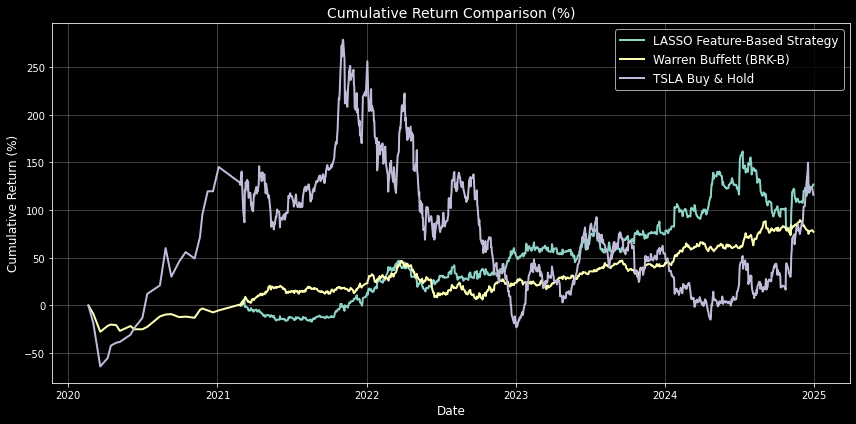

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('dark_background')



# Load your Tesla feature mart
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create your features and target
df = create_advanced_features(df)  # Your existing function
y = df['log_return'].copy()


# Load competitor data
try:
    competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
    competitor_returns.index = pd.to_datetime(competitor_returns.index)
    use_competitors = True
    print("Competitor data loaded successfully.")
except:
    print("Competitor data not found. Proceeding without competitor features.")
    use_competitors = False

# Prepare features
X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)

features_to_remove = ['Return_1D', 'Return_5D']
X = X.drop(columns=features_to_remove, errors='ignore')


# Merge with competitor returns if available
if use_competitors:
    X = pd.concat([X, competitor_returns], axis=1)
    print(f"Added {competitor_returns.shape[1]} competitor features.")

# Clean data
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(method='ffill').fillna(method='bfill')
y = y.fillna(method='ffill').fillna(method='bfill')

# Make sure X and y are aligned
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx]
y = y.loc[common_idx]

# Drop any remaining NaN values
mask = ~(np.isnan(y) | X.isna().any(axis=1))
X = X.loc[mask]
y = y.loc[mask]

# Check that there are no NaN values left
print(f"NaNs in X: {X.isna().sum().sum()}")
print(f"NaNs in y: {y.isna().sum()}")
print(f"Total features: {X.shape[1]}")

# Standardize features (important for LASSO)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Find optimal alpha using cross-validation
lasso_cv = LassoCV(cv=TimeSeriesSplit(n_splits=5), random_state=42, max_iter=10000)
lasso_cv.fit(X_scaled, y)
optimal_alpha = lasso_cv.alpha_

print(f"Optimal alpha: {optimal_alpha}")

# Run LASSO with optimal alpha
lasso_model = Lasso(alpha=optimal_alpha, fit_intercept=True, max_iter=10000)
lasso_model.fit(X_scaled, y)

# Create DataFrame with feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_model.coef_
})

# Filter only non-zero coefficients (selected features)
selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values(
    by='Coefficient', key=abs, ascending=False
)

print(f"\nLASSO selected {len(selected_features)} out of {X.shape[1]} features")

# Display selected features
print("\nFeatures Selected by LASSO:")
print(selected_features)

# Test these features in an OLS model
X_top = X[selected_features['Feature']]
X_top = sm.add_constant(X_top)
model = sm.OLS(y, X_top).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print("\nOLS Model with LASSO-selected features:")
print(model.summary())

# Calculate correlation of predictions with actual returns
y_pred = model.predict(X_top)
correlation = np.corrcoef(y, y_pred)[0, 1]
print(f"\nCorrelation between actual and predicted returns: {correlation:.4f}")

# Implement LASSO-based trading strategy
def lasso_feature_trading_strategy(df, selected_features):
    """
    Implement a trading strategy using LASSO-selected features
    """
    print("\nLASSO Feature-Based Trading Model")
    print("-" * 50)
    
    def add_proper_lags(X_data):
        # Ensure all features use proper lags
        for col in X_data.columns:
            if not col.endswith('_lag1') and not col.endswith('_lag2'):
                X_data[col] = X_data[col].shift(1)  # Add 1-day lag to prevent lookahead
        return X_data
    
    # Create advanced features
    df = create_advanced_features(df)
    
    # Load competitor data
    try:
        competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
        competitor_returns.index = pd.to_datetime(competitor_returns.index)
        use_competitors = True
    except:
        print("Competitor data not found. Proceeding without competitor features.")
        use_competitors = False
    
    # Prepare features and target
    y = df['log_return'].copy()
    X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)
    X=add_proper_lags(X)

    def add_noise(predictions, noise_level=0.1):
        noise = np.random.normal(0, noise_level, len(predictions))
        return predictions + noise
    
    # Merge with competitor returns if available
    if use_competitors:
        X = pd.concat([X, competitor_returns], axis=1)
    
    # Clean data
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(method='ffill').fillna(method='bfill')
    y = y.fillna(method='ffill').fillna(method='bfill')
    
    # Keep only selected features
    feature_list = selected_features['Feature'].tolist()
    available_features = [f for f in feature_list if f in X.columns]
    X_selected = X[available_features]
    
    # Ensure data alignment
    common_idx = y.index.intersection(X_selected.index)
    y = y.loc[common_idx]
    X_selected = X_selected.loc[common_idx]
    
    # Sort by date
    y = y.sort_index()
    X_selected = X_selected.sort_index()
    
    # Remove any remaining NaN values
    mask = ~(y.isna() | X_selected.isna().any(axis=1))
    y = y[mask]
    X_selected = X_selected[mask]
    df_clean = df.loc[y.index]

    # Modified walk-forward optimization
    all_predictions = np.zeros(len(X_selected))
    min_train_size = 504  # 2 years minimum training data
    window_size = 252  # 1 year of trading days
    step_size = 63    # 3 months step
    
    # Walk-forward prediction with minimum training size
    for i in range(min_train_size, len(X_selected), step_size):
        # Define train and test periods
        train_data = slice(0, i)
        test_data = slice(i, min(i + window_size, len(X_selected)))
        
        # Split data
        X_train = X_selected.iloc[train_data]
        X_test = X_selected.iloc[test_data]
        y_train = y.iloc[train_data]
        
        if len(X_train) > 0 and len(y_train) > 0:  # Check for non-empty data
            # Fit model
            X_train_const = sm.add_constant(X_train)
            model = sm.OLS(y_train, X_train_const).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
            
            # Make predictions
            X_test_const = sm.add_constant(X_test)
            predictions = model.predict(X_test_const)
            
            # Add small amount of noise
            predictions = add_noise(predictions, noise_level=0.001)
            
            # Store predictions
            all_predictions[test_data] = predictions

    # Calculate final train/test split for metrics
    train_size = int(len(X_selected) * 0.8)
    X_train = X_selected.iloc[:train_size]
    X_test = X_selected.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    
    # Fit final model on training data
    X_train_const = sm.add_constant(X_train)
    final_model = sm.OLS(y_train, X_train_const).fit(cov_type='HAC', cov_kwds={'maxlags': 5})
    
    # Calculate predictions for metrics
    y_train_pred = final_model.predict(X_train_const)
    X_test_const = sm.add_constant(X_test)
    y_test_pred = final_model.predict(X_test_const)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)  # Now test_rmse is properly defined

    # Print performance metrics
    print("\nModel Performance Metrics:")
    print("-" * 50)
    print(f"Training MSE: {train_mse:.6f}")
    print(f"Testing MSE: {test_mse:.6f}")
    print(f"Training RMSE: {train_rmse:.6f}")
    print(f"Testing RMSE: {test_rmse:.6f}")
    print(f"Training R²: {final_model.rsquared:.4f}")
    print(f"Testing R²: {1 - ((y_test - y_test_pred) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum():.4f}")

    # Predict on all data for position sizing
    X_all_const = sm.add_constant(X_selected)
    all_predictions = model.predict(X_all_const)    
   
    
    # Apply position sizing and risk management (using the same risk model as the PCA strategy)
    positions_df = position_sizing_and_risk_management(
        df_clean, all_predictions, model, X_selected, max_risk_per_trade=0.02
    )
    
    # Final positions for trading
    final_positions = positions_df['final_position']
    final_positions.name = 'TSLA'  # Name for Warren Buffett comparison
    
    return model, final_positions, y

# Run the LASSO feature-based trading strategy and compare with Warren Buffett
lasso_model, lasso_positions, lasso_y = lasso_feature_trading_strategy(df, selected_features)

# Calculate strategy returns
lasso_strategy_returns = lasso_positions.shift(1) * lasso_y
lasso_strategy_returns = lasso_strategy_returns.dropna()

# Compare with Warren Buffett
lasso_comparison = compare_with_buffett(
    strategy_returns=lasso_strategy_returns,
    strategy_name="LASSO Feature-Based Strategy",
    initial_capital=100000,
    position_series=lasso_positions
)

## Feature selection using Random forest 

Competitor data loaded successfully.
Added 22 competitor features.
Total features: 99
Total observations: 1187

Top 20 Features Selected by Random Forest:
                  Feature  Importance
95               XLY_ETFs    0.109493
9              BBP_10_2.0    0.074413
96              ARKK_ETFs    0.065212
98              IDRV_ETFs    0.060720
97              DRIV_ETFs    0.051807
18                 Mkt-RF    0.041194
77          NIO_EV_makers    0.031655
89       AAPL_Tech_Giants    0.029571
90       NVDA_Tech_Giants    0.024445
1                  RSI_15    0.018425
91        AMD_Tech_Giants    0.016855
94       INTC_Tech_Giants    0.015567
22                    CMA    0.014583
88  RACE_Traditional_Auto    0.013665
84     F_Traditional_Auto    0.012830
92        TSM_Tech_Giants    0.012332
79         LCID_EV_makers    0.012303
93       QCOM_Tech_Giants    0.011394
3            MACDh_5_20_9    0.011339
20                    HML    0.010186


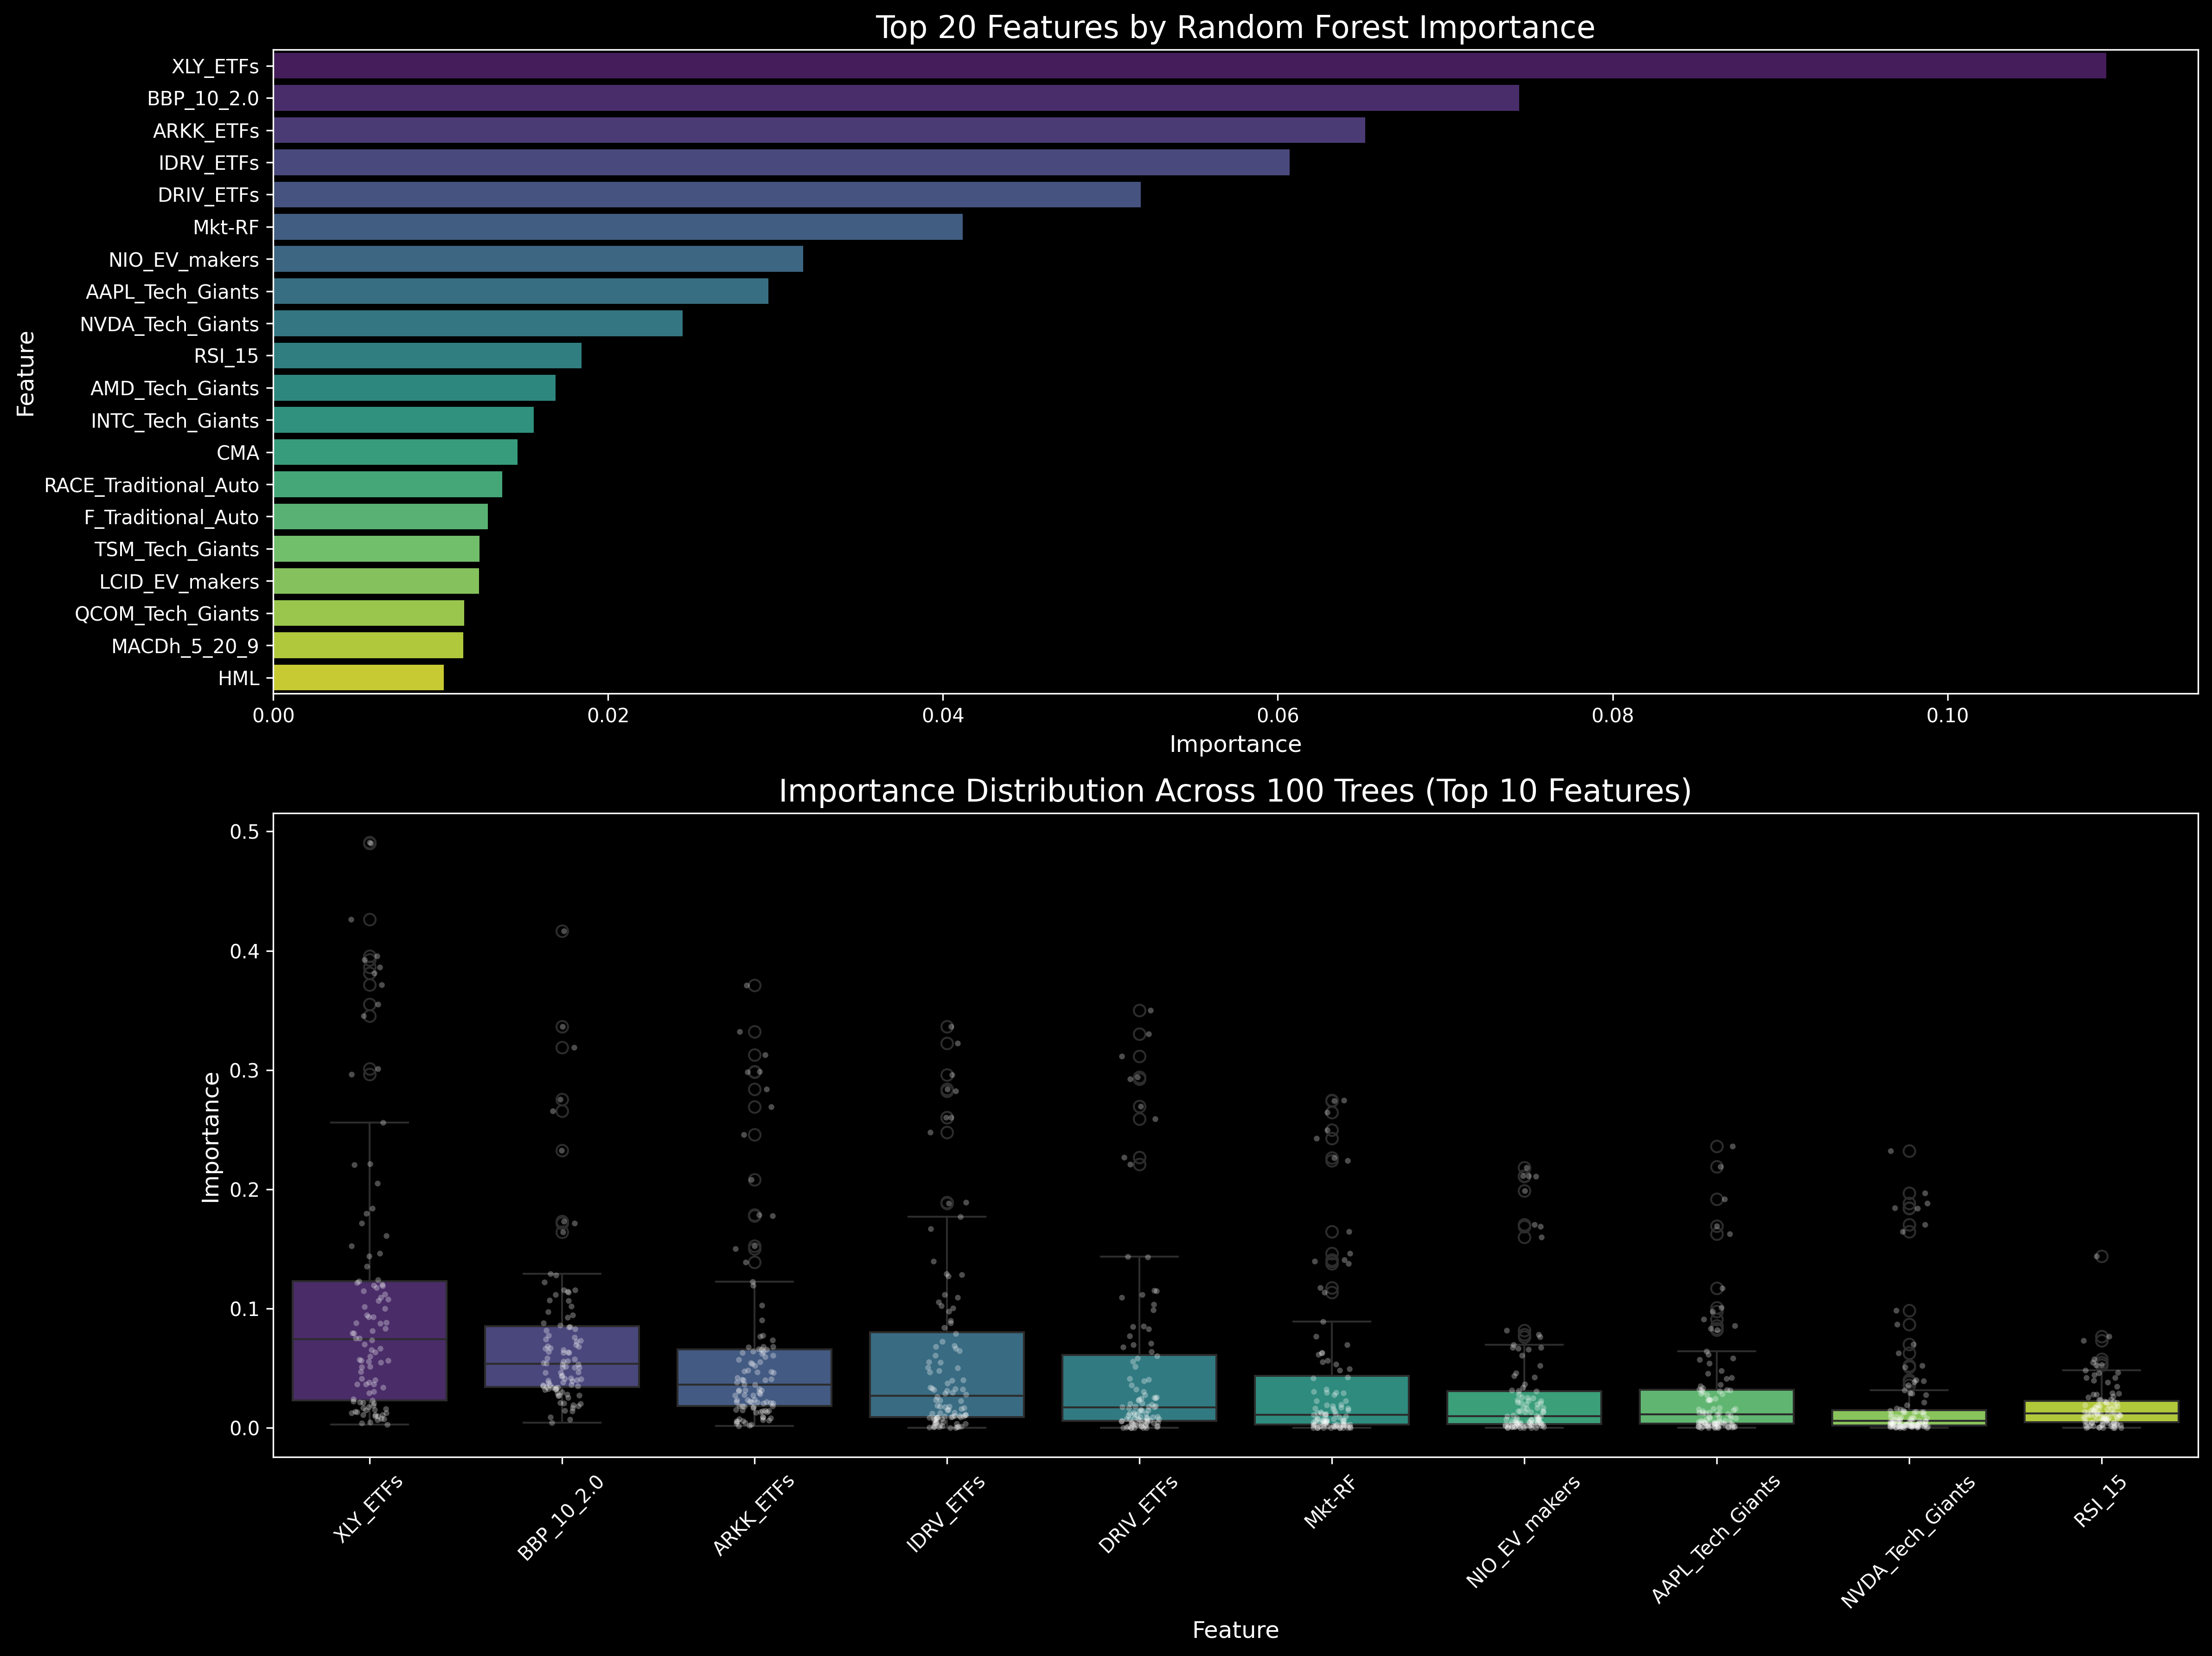


Features for your trading model:
['XLY_ETFs', 'BBP_10_2.0', 'ARKK_ETFs', 'IDRV_ETFs', 'DRIV_ETFs', 'Mkt-RF', 'NIO_EV_makers', 'AAPL_Tech_Giants', 'NVDA_Tech_Giants', 'RSI_15', 'AMD_Tech_Giants', 'INTC_Tech_Giants', 'CMA', 'RACE_Traditional_Auto', 'F_Traditional_Auto', 'TSM_Tech_Giants', 'LCID_EV_makers', 'QCOM_Tech_Giants', 'MACDh_5_20_9', 'HML']


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Set dark mode for visualizations
plt.style.use('dark_background')

# Load data and create features
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Create advanced features using your existing function
df = create_advanced_features(df)

# Prepare target variable
y = df['log_return'].copy()

# Load competitor data if available
try:
    competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
    competitor_returns.index = pd.to_datetime(competitor_returns.index)
    use_competitors = True
    print("Competitor data loaded successfully.")
except:
    print("Competitor data not found. Proceeding without competitor features.")
    use_competitors = False

# Prepare features
X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)

features_to_remove = ['Return_1D', 'Return_5D']
X = X.drop(columns=features_to_remove, errors='ignore')


# Merge with competitor returns if available
if use_competitors:
    X = pd.concat([X, competitor_returns], axis=1)
    print(f"Added {competitor_returns.shape[1]} competitor features.")

# Clean data
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(method='ffill').fillna(method='bfill')
y = y.fillna(method='ffill').fillna(method='bfill')

# Make sure X and y are aligned
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx]
y = y.loc[common_idx]

# Drop any remaining NaN values
mask = ~(np.isnan(y) | X.isna().any(axis=1))
X = X.loc[mask]
y = y.loc[mask]

print(f"Total features: {X.shape[1]}")
print(f"Total observations: {X.shape[0]}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Define the Random Forest model with optimal parameters
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

# Fit the model
model.fit(X_scaled, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', key=abs, ascending=False)

# Display top 20 features
top_features = feature_importance.head(20)
print("\nTop 20 Features Selected by Random Forest:")
print(top_features)

# Create a multi-level visualization of feature importance
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), dpi=300)

# Top features bar chart
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_features,
    palette='viridis',
    ax=axes[0]
)
axes[0].set_title('Top 20 Features by Random Forest Importance', fontsize=16)
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)
axes[0].tick_params(axis='y', labelsize=10)

# Detailed importance distribution for top 10 features
df_feature_all = pd.DataFrame(
    [tree.feature_importances_ for tree in model.estimators_], 
    columns=X.columns
)
df_top10 = df_feature_all[top_features['Feature'].head(10)]
df_feature_long = pd.melt(df_top10, var_name='Feature', value_name='Importance')

sns.boxplot(
    x='Feature', 
    y='Importance', 
    data=df_feature_long,
    palette='viridis',
    ax=axes[1]
)
sns.stripplot(
    x='Feature', 
    y='Importance', 
    data=df_feature_long,
    color='white',
    alpha=0.3,
    size=3,
    ax=axes[1]
)
axes[1].set_title('Importance Distribution Across 100 Trees (Top 10 Features)', fontsize=16)
axes[1].set_xlabel('Feature', fontsize=12)
axes[1].set_ylabel('Importance', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

# Export top features list for easy use in your model
top_features_list = top_features['Feature'].tolist()
print("\nFeatures for your trading model:")
print(top_features_list)

## Model 2 Random Forest Regressor


Random Forest Trading Model
--------------------------------------------------
Shape after feature creation: (1187, 85)
Using 19 out of 20 selected features
Features used: ['return_lag_1', 'XLY_ETFs', 'BBP_10_2.0', 'ARKK_ETFs', 'IDRV_ETFs', 'DRIV_ETFs', 'Mkt-RF', 'NIO_EV_makers', 'NVDA_Tech_Giants', 'AAPL_Tech_Giants', 'AMD_Tech_Giants', 'RACE_Traditional_Auto', 'RSI_15', 'CMA', 'TSM_Tech_Giants', 'INTC_Tech_Giants', 'GM_Traditional_Auto', 'LCID_EV_makers', 'MACDh_5_20_9']

Model Performance:
--------------------------------------------------
Training RMSE: 0.026813
Testing RMSE: 0.028652

Trading Performance:
--------------------------------------------------
Total Return: 37.41%
Annual Return: 6.98%
Sharpe Ratio: 0.27
Max Drawdown: -33.66%
Win Rate: 40.10%


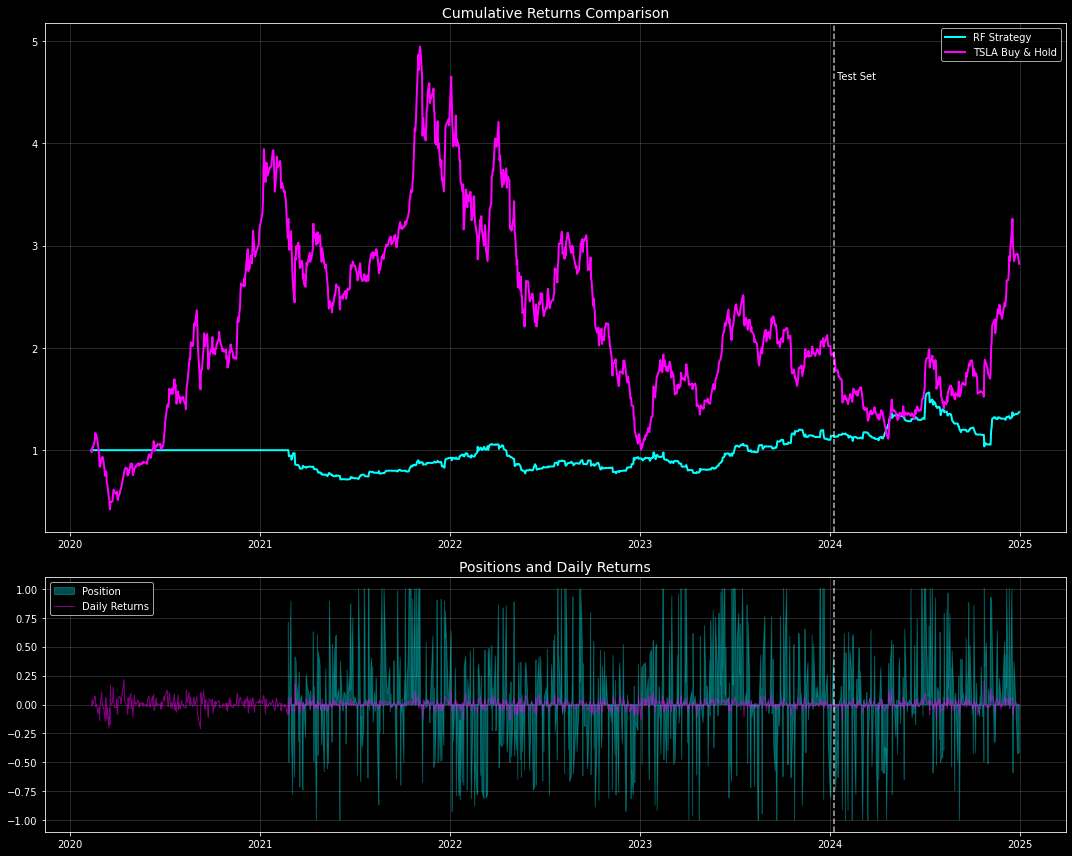

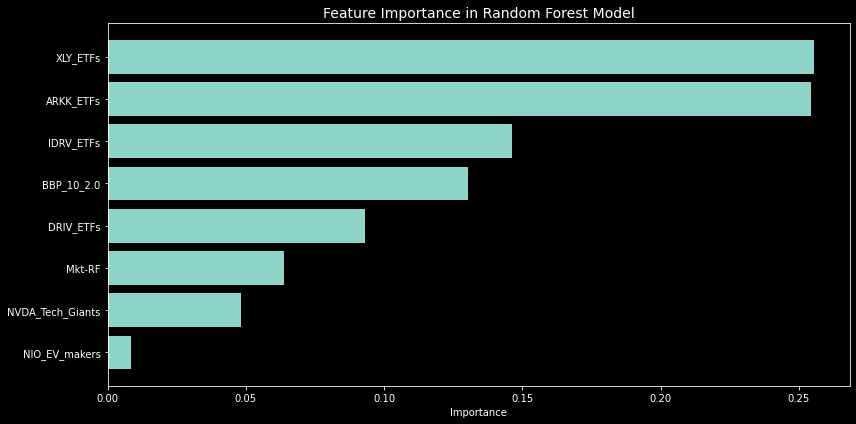

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


===== Random Forest Strategy vs. Warren Buffett Performance Summary =====


Metric,Random Forest Strategy,Warren Buffett (BRK-B),TSLA Buy & Hold
Total Return,37.41%,77.04%,184.82%
Annual Return,6.98%,12.89%,24.88%
Sharpe Ratio,0.45,0.66,0.67
Maximum Drawdown,-33.66%,-31.60%,-79.64%
Annual Volatility,26.29%,22.20%,66.46%
Final Balance,"$137,411.10","$177,039.28","$284,824.58"
Win Rate,40.10%,53.66%,52.91%


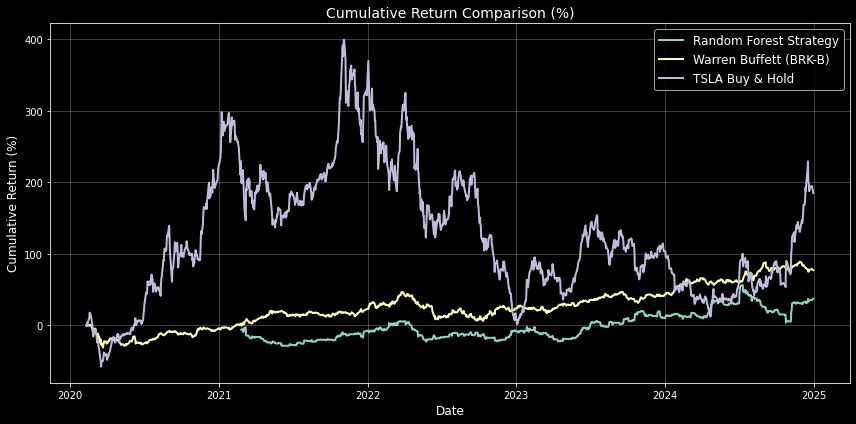

In [84]:
def rf_trading_strategy(df):
    """Random Forest-based trading strategy using selected top features"""
    print("\nRandom Forest Trading Model")
    print("-" * 50)
    

    # Selected features from Random Forest importance analysis
    selected_features = [
        'return_lag_1', 'XLY_ETFs', 'BBP_10_2.0', 'ARKK_ETFs', 'IDRV_ETFs', 
        'DRIV_ETFs', 'Return_lag_5', 'Mkt-RF', 'NIO_EV_makers', 'NVDA_Tech_Giants',
        'AAPL_Tech_Giants', 'AMD_Tech_Giants', 'RACE_Traditional_Auto', 'RSI_15',
        'CMA', 'TSM_Tech_Giants', 'INTC_Tech_Giants', 'GM_Traditional_Auto',
        'LCID_EV_makers', 'MACDh_5_20_9'
    ]
    
    # Create advanced features
    df = create_advanced_features(df)
    print(f"Shape after feature creation: {df.shape}")
    
    # Load competitor data
    try:
        competitor_returns = pd.read_csv('tesla_competitors.csv', index_col=0)
        competitor_returns.index = pd.to_datetime(competitor_returns.index)
        use_competitors = True
    except:
        print("Competitor data not found. Proceeding without competitor features.")
        use_competitors = False
    
    # Prepare features and target
    y = df['log_return'].copy()
    X = df.drop(['open', 'high', 'low', 'close', 'volume', 'log_return'], axis=1)
    
    # Merge with competitor returns if available
    if use_competitors:
        X = pd.concat([X, competitor_returns], axis=1)
    
    # Keep only selected features that are available
    available_features = [f for f in selected_features if f in X.columns]
    X_selected = X[available_features]
    
    print(f"Using {len(available_features)} out of {len(selected_features)} selected features")
    print(f"Features used: {available_features}")
    
    # Clean data
    X_selected = X_selected.replace([np.inf, -np.inf], np.nan)
    X_selected = X_selected.fillna(method='ffill').fillna(method='bfill')
    y = y.fillna(method='ffill').fillna(method='bfill')
    
    # Ensure data alignment
    common_idx = y.index.intersection(X_selected.index)
    y = y.loc[common_idx]
    X_selected = X_selected.loc[common_idx]
    df_clean = df.loc[common_idx]
    
    # Remove any remaining NaN values
    mask = ~(y.isna() | X_selected.isna().any(axis=1))
    y = y[mask]
    X_selected = X_selected[mask]
    df_clean = df_clean.loc[mask]
    
    # Time-based train-test split (80% train, 20% test)
    train_size = int(len(X_selected) * 0.8)
    X_train = X_selected.iloc[:train_size]
    X_test = X_selected.iloc[train_size:]
    y_train = y.iloc[:train_size]
    y_test = y.iloc[train_size:]
    split_date = y.index[train_size]
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(
    n_estimators=50,          # Increased from 300
    max_depth=3,               # Reduced from 5
    min_samples_leaf=15,       # Increased from 10
    min_samples_split=25,      # Increased from 20
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

    model.fit(X_train_scaled, y_train)

    
    def filter_features(X, model, threshold=0.01):
        importances = pd.DataFrame({
            'feature': X.columns,
            'importance': model.feature_importances_
        })
        return X[importances[importances['importance'] > threshold]['feature']]
    
    # Apply feature filtering
    important_features = filter_features(X_selected, model, threshold=0.03)
    X_selected = X_selected[important_features.columns]
    X_train = X_train[important_features.columns]
    X_test = X_test[important_features.columns]
    
    # Refit model with filtered features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model.fit(X_train_scaled, y_train)

    # Calculate predictions and RMSE
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Generate all predictions for trading
    X_scaled = scaler.transform(X_selected)
    all_predictions = model.predict(X_scaled)
    
    
    # Calculate prediction standard deviation
    prediction_std = np.zeros(len(all_predictions))
    window_size = 20
    for i in range(window_size, len(all_predictions)):
        pred_window = all_predictions[i-window_size:i]
        prediction_std[i] = np.std(pred_window)
    prediction_std[:window_size] = np.std(all_predictions[:window_size])
    
    model_stats = pd.DataFrame({
        'prediction': all_predictions,
        'prediction_std': prediction_std
    }, index=X_selected.index)

    
    # Create mock OLS model for compatibility
    class MockOLSResults:
        def get_prediction(self, X):
            class PredictionResults:
                def __init__(self, mean_se):
                    self._mean_se = mean_se
                def summary_frame(self):
                    return pd.DataFrame({'mean_se': self._mean_se})
            return PredictionResults(model_stats['prediction_std'])
    
    mock_model = MockOLSResults()
    
    # Create PCA-like feature matrix for compatibility
    X_pca_like = pd.DataFrame(
        X_scaled,  # Use standardized features
        index=X_selected.index,
        columns=[f'PC{i+1}' for i in range(X_scaled.shape[1])]
    )
    
    # Apply position sizing
    positions_df = position_sizing_and_risk_management(
        df_clean,
        model_stats['prediction'],
        mock_model,
        X_pca_like,
        max_risk_per_trade=0.03
    )
    
    # Get final positions and calculate returns
    final_positions = positions_df['final_position']
    final_positions.name = 'TSLA'
    strategy_returns = final_positions.shift(1) * y
    
    # Performance metrics
    cum_returns = (1 + strategy_returns.fillna(0)).cumprod()
    cum_asset = (1 + y.fillna(0)).cumprod()
    
    total_return = cum_returns.iloc[-1] - 1
    annual_return = (1 + total_return) ** (252/len(strategy_returns)) - 1
    volatility = strategy_returns.std() * np.sqrt(252)
    sharpe = annual_return / volatility if volatility > 0 else 0
    max_drawdown = (cum_returns / cum_returns.cummax() - 1).min()
    
    # Print performance metrics
    print("\nModel Performance:")
    print("-" * 50)
    print(f"Training RMSE: {train_rmse:.6f}")
    print(f"Testing RMSE: {test_rmse:.6f}")
    
    print("\nTrading Performance:")
    print("-" * 50)
    print(f"Total Return: {total_return:.2%}")
    print(f"Annual Return: {annual_return:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Win Rate: {(strategy_returns > 0).mean():.2%}")
    
    # Enhanced visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), gridspec_kw={'height_ratios': [2, 1]})
    
    # Cumulative returns plot
    ax1.plot(cum_returns, label='RF Strategy', color='cyan', linewidth=2)
    ax1.plot(cum_asset, label='TSLA Buy & Hold', color='magenta', linewidth=2)
    ax1.axvline(x=split_date, color='white', linestyle='--', alpha=0.7)
    ax1.text(split_date, ax1.get_ylim()[1]*0.9, ' Test Set', verticalalignment='center')
    ax1.set_title('Cumulative Returns Comparison', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.2)
    
    # Position and returns plot
    ax2.fill_between(final_positions.index, final_positions, color='cyan', alpha=0.3, label='Position')
    ax2.plot(y.index, y, color='magenta', alpha=0.5, label='Daily Returns', linewidth=1)
    ax2.axvline(x=split_date, color='white', linestyle='--', alpha=0.7)
    ax2.set_title('Positions and Daily Returns', fontsize=14)
    ax2.legend()
    ax2.grid(alpha=0.2)
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance plot
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': X_selected.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title('Feature Importance in Random Forest Model', fontsize=14)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return model, final_positions, strategy_returns, y

import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('INFO6105_Final_TSLA_FeatureMart (1).xls')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Run Random Forest trading strategy
rf_model, rf_positions, rf_strategy_returns, rf_y = rf_trading_strategy(df)

# Compare with Warren Buffett
rf_comparison = compare_with_buffett(
    strategy_returns=rf_strategy_returns,
    strategy_name="Random Forest Strategy",
    initial_capital=100000,
    position_series=rf_positions
)